# Tata Steel Machine Failure Prediction - Detailed ML Notebook

## Goal
Build, compare, and explain classification models that predict machine failure early enough to enable proactive maintenance.


## Business Context
Machine failures in steel manufacturing can cause downtime, output loss, and maintenance escalation. 
This notebook is structured to prioritize **early failure detection** under class imbalance and convert model results into operational decisions.


## Modeling Strategy
- Target is rare, so **PR-AUC, Recall, and F1** are primary metrics.
- Use **stratified split** and **class-weighted models** to handle imbalance.
- Tune **classification threshold** (not only model type) to control missed failures vs false alarms.
- Exclude `TWF/HDF/PWF/OSF/RNF` by default because they may leak post-event information in real deployments.


In [1]:
import warnings
# Suppress non-critical warnings for cleaner notebook output
warnings.filterwarnings("ignore")

# Used to save evaluation outputs to JSON
import json
from pathlib import Path

# Used to persist trained model artifacts
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# clone() keeps estimator configs reusable across loops
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Standardize chart style across the notebook
sns.set_theme(style="whitegrid")
# Fix seed to keep splits and model behavior reproducible
RANDOM_STATE = 42


In [2]:
try:
    # Import XGBoost only when available in environment
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None

try:
    # Import LightGBM only when available in environment
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = None

# Show optional dependency availability before model setup
print("xgboost available:", XGBClassifier is not None)
print("lightgbm available:", LGBMClassifier is not None)


xgboost available: True
lightgbm available: True


## Data Loading and First Checks


In [3]:
# Centralized paths and constants used across notebook
TRAIN_PATH = "Dataset/train.csv"
TEST_PATH = "Dataset/test.csv"
TARGET = "Machine failure"
ID_COL = "id"
# Potentially leakage-prone columns kept configurable
LEAKAGE_COLS = ["TWF", "HDF", "PWF", "OSF", "RNF"]
INCLUDE_LEAKAGE_COLS = False

# Load train data for fitting and validation
train_df = pd.read_csv(TRAIN_PATH)
# Load test data for inference export
test_df = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Failure rate (%):", round(train_df[TARGET].mean() * 100, 3))

# Quick schema and quality summary table
summary = pd.DataFrame({
    "dtype": train_df.dtypes.astype(str),
    "missing": train_df.isna().sum(),
    "n_unique": train_df.nunique(),
})
summary.head(14)


Train shape: (136429, 14)
Test shape: (90954, 13)
Failure rate (%): 1.574


,dtype,missing,n_unique
id,int64,0,136429
Product ID,object,0,9976
Type,object,0,3
Air temperature [K],float64,0,95
Process temperature [K],float64,0,81
Rotational speed [rpm],int64,0,952
Torque [Nm],float64,0,611
Tool wear [min],int64,0,246
Machine failure,int64,0,2
TWF,int64,0,2


   class   count  share_pct
0      0  134281     98.426
1      1    2148      1.574


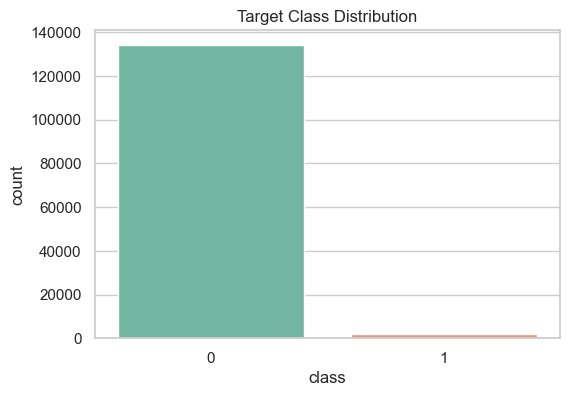

In [4]:
# Class imbalance view
# Compute class counts and percentage share
class_counts = train_df[TARGET].value_counts().rename_axis("class").reset_index(name="count")
class_counts["share_pct"] = (class_counts["count"] / class_counts["count"].sum() * 100).round(3)
print(class_counts)

# Plot imbalance to justify PR-focused evaluation
plt.figure(figsize=(6, 4))
sns.barplot(data=class_counts, x="class", y="count", palette="Set2")
plt.title("Target Class Distribution")
plt.show()


## Feature Engineering
Engineered features add process context:
- `Temperature diff [K]`: process-air thermal gap
- `Power [kW]`: mechanical load proxy from speed and torque
- `Torque per wear`: load normalized by tool condition


In [5]:
# Single feature-engineering function to keep train/test transformations identical
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    # Copy input to avoid side-effects
    out = df.copy()
    # Thermal delta between process and ambient conditions
    out["Temperature diff [K]"] = out["Process temperature [K]"] - out["Air temperature [K]"]
    # Approximate mechanical power derived from speed and torque
    out["Power [kW]"] = (2 * np.pi * out["Rotational speed [rpm]"] * out["Torque [Nm]"]) / (60 * 1000)
    # Normalize torque by tool wear to capture stress efficiency
    out["Torque per wear"] = out["Torque [Nm]"] / (out["Tool wear [min]"] + 1)
    out["Product Type Prefix"] = out["Product ID"].astype(str).str[0]
    return out

# Engineer training dataset features
train_f = build_features(train_df)
# Engineer test dataset features using same logic
test_f = build_features(test_df)

categorical_features = ["Type", "Product Type Prefix"]
numeric_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
    "Temperature diff [K]",
    "Power [kW]",
    "Torque per wear",
]

# Optional switch for experimental leakage-feature inclusion
if INCLUDE_LEAKAGE_COLS:
    numeric_features = numeric_features + LEAKAGE_COLS

# Assemble model input matrix
X = train_f[categorical_features + numeric_features]
# Assemble target vector
y = train_f[TARGET]
X_test = test_f[categorical_features + numeric_features]

print("Feature matrix shape:", X.shape)
print("Using leakage columns:", INCLUDE_LEAKAGE_COLS)
X.head()


Feature matrix shape: (136429, 10)
Using leakage columns: False


,Type,Product Type Prefix,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temperature diff [K],Power [kW],Torque per wear
0,L,L,300.6,309.6,1596,36.1,140,9.0,6.033492,0.256028
1,M,M,302.6,312.1,1759,29.1,200,9.5,5.360280,0.144776
2,L,L,299.3,308.5,1805,26.5,25,9.2,5.009008,1.019231
3,L,L,301.0,310.9,1524,44.3,197,9.9,7.069966,0.223737
4,M,M,298.0,309.0,1641,35.4,34,11.0,6.083317,1.011429


## Train/Validation Split
We use stratified split to preserve failure rate in both sets.


In [6]:
# Stratified split preserves failure class ratio across sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

# Sanity-check split sizes and label balance
print("Train split:", X_train.shape, "Validation split:", X_valid.shape)
print("Train failure rate (%):", round(y_train.mean() * 100, 3))
print("Valid failure rate (%):", round(y_valid.mean() * 100, 3))


Train split: (109143, 10) Validation split: (27286, 10)
Train failure rate (%): 1.574
Valid failure rate (%): 1.576


In [7]:
# Define preprocessing for categorical and numerical blocks
preprocessor = ColumnTransformer(
    transformers=[
        (
            # Categorical branch: mode imputation + one-hot encoding
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            categorical_features,
        ),
        (
            # Numeric branch: median imputation + scaling
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
    ],
    remainder="drop",
)

# Compute neg/pos ratio for imbalance-aware boosters
ratio = (len(y_train) - y_train.sum()) / max(y_train.sum(), 1)
print("Class ratio (neg/pos):", round(float(ratio), 2))

# Initialize baseline family of classifiers
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=350,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=400,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
}

# Add XGBoost candidate if installed
if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier(
        n_estimators=450,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="aucpr",
        scale_pos_weight=float(ratio),
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method="hist",
    )

# Add LightGBM candidate if installed
if LGBMClassifier is not None:
    models["LightGBM"] = LGBMClassifier(
        n_estimators=550,
        learning_rate=0.05,
        num_leaves=31,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        objective="binary",
        n_jobs=-1,
        verbose=-1,
    )

print("Models:", list(models.keys()))


Class ratio (neg/pos): 62.53
Models: ['LogisticRegression', 'RandomForest', 'ExtraTrees', 'XGBoost', 'LightGBM']


## Cross-Validation Snapshot (PR-AUC)
This gives a stability check before holdout threshold tuning.


In [8]:
# Use stratified K-fold for robust PR-AUC comparison
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
cv_rows = []

# Evaluate each model under identical CV protocol
for name, estimator in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", clone(estimator))])
    # Collect PR-AUC per fold
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring="average_precision", cv=cv, n_jobs=1)
    cv_rows.append({
        "model": name,
        "cv_pr_auc_mean": cv_scores.mean(),
        "cv_pr_auc_std": cv_scores.std(),
    })

# Rank models by mean PR-AUC
cv_df = pd.DataFrame(cv_rows).sort_values("cv_pr_auc_mean", ascending=False)
cv_df


,model,cv_pr_auc_mean,cv_pr_auc_std
3,XGBoost,0.458475,0.019734
4,LightGBM,0.457789,0.026066
1,RandomForest,0.421730,0.019144
2,ExtraTrees,0.376047,0.023078
0,LogisticRegression,0.288606,0.021642


## Holdout Evaluation with Threshold Optimization
Model ranking uses PR-AUC first, then F1 and ROC-AUC.


In [9]:
# Grid-search threshold to maximize F1 on validation data
def best_threshold_for_f1(y_true, y_prob):
    thresholds = np.linspace(0.05, 0.95, 91)
    f1s = [f1_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thresholds]
    best_idx = int(np.argmax(f1s))
    return float(thresholds[best_idx]), float(f1s[best_idx])


# Centralized metric calculation helper
def evaluate(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "pr_auc": float(average_precision_score(y_true, y_prob)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
    }

# Accumulate per-model validation results
rows = []
fitted = {}
valid_probs = {}

# Train and evaluate each candidate model
for name, estimator in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", clone(estimator))])
    pipe.fit(X_train, y_train)
    # Use probabilities for threshold tuning
    valid_prob = pipe.predict_proba(X_valid)[:, 1]

    th, _ = best_threshold_for_f1(y_valid, valid_prob)
    metrics = evaluate(y_valid, valid_prob, th)
    metrics.update({"threshold": th, "model": name})

    rows.append(metrics)
    fitted[name] = pipe
    valid_probs[name] = valid_prob

# Create ranking table used for final model choice
leaderboard = pd.DataFrame(rows).sort_values(["pr_auc", "f1", "roc_auc"], ascending=False)
leaderboard


,roc_auc,pr_auc,f1,precision,recall,balanced_accuracy,threshold,model
3,0.918111,0.445038,0.513545,0.520286,0.506977,0.749746,0.92,XGBoost
4,0.915615,0.434717,0.500542,0.468560,0.537209,0.763727,0.86,LightGBM
1,0.900700,0.401509,0.492341,0.464876,0.523256,0.756806,0.20,RandomForest
2,0.891870,0.375331,0.476553,0.523677,0.437209,0.715421,0.30,ExtraTrees
0,0.860755,0.259381,0.337272,0.313373,0.365116,0.676154,0.88,LogisticRegression


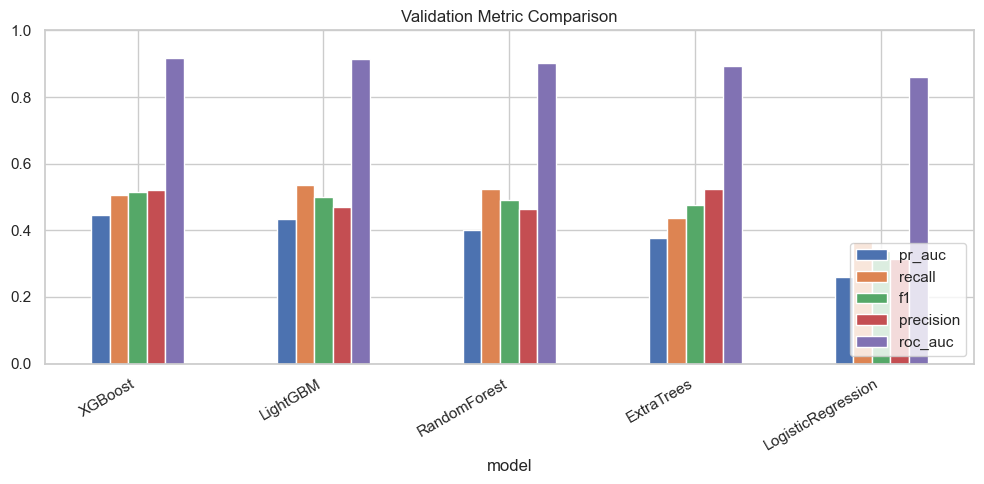

In [10]:
# Visual metric comparison
# Compare core metrics side-by-side
plot_cols = ["pr_auc", "recall", "f1", "precision", "roc_auc"]
leaderboard_plot = leaderboard[["model"] + plot_cols].set_index("model")

# Render a compact chart for quick model trade-off review
ax = leaderboard_plot.plot(kind="bar", figsize=(10, 5))
ax.set_ylim(0, 1)
ax.set_title("Validation Metric Comparison")
ax.legend(loc="lower right")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


Best model: XGBoost
Best threshold: 0.92
              precision    recall  f1-score   support

           0     0.9921    0.9925    0.9923     26856
           1     0.5203    0.5070    0.5135       430

    accuracy                         0.9849     27286
   macro avg     0.7562    0.7497    0.7529     27286
weighted avg     0.9847    0.9849    0.9848     27286



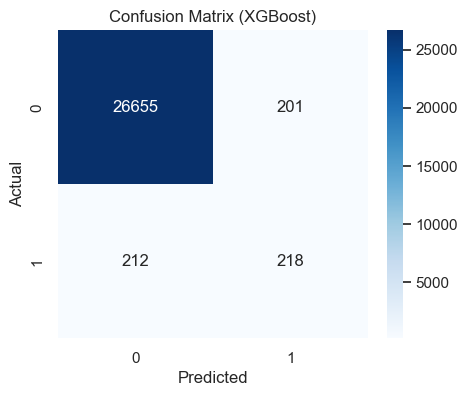

In [11]:
# Select top model from leaderboard
best_model_name = leaderboard.iloc[0]["model"]
best_threshold = float(leaderboard.iloc[0]["threshold"])
best_model = fitted[best_model_name]

print("Best model:", best_model_name)
print("Best threshold:", round(best_threshold, 3))

valid_prob = valid_probs[best_model_name]
# Apply tuned threshold to obtain final class predictions
valid_pred = (valid_prob >= best_threshold).astype(int)

print(classification_report(y_valid, valid_pred, digits=4))

# Confusion matrix highlights missed failures vs false alarms
cm = confusion_matrix(y_valid, valid_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix ({best_model_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


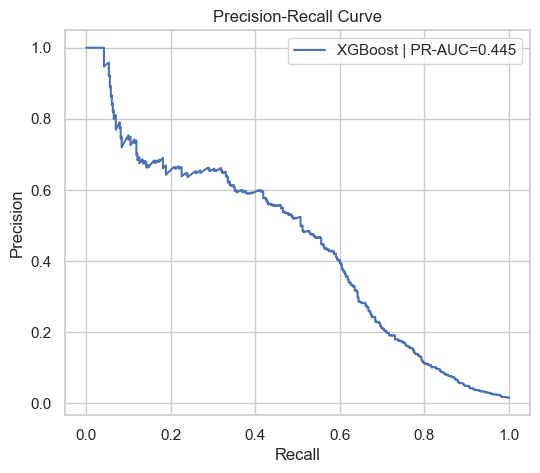

In [12]:
# Precision-Recall curve for selected model
# PR curve helps visualize precision-recall trade-off
precision, recall, thresholds = precision_recall_curve(y_valid, valid_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"{best_model_name} | PR-AUC={average_precision_score(y_valid, valid_prob):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [13]:
# Threshold sensitivity table (operational tuning aid)
# Evaluate business trade-offs across many thresholds
threshold_grid = np.round(np.linspace(0.1, 0.9, 17), 2)
threshold_rows = []

# Measure precision, recall, and F1 at each threshold
for th in threshold_grid:
    yp = (valid_prob >= th).astype(int)
    threshold_rows.append({
        "threshold": th,
        "precision": precision_score(y_valid, yp, zero_division=0),
        "recall": recall_score(y_valid, yp, zero_division=0),
        "f1": f1_score(y_valid, yp, zero_division=0),
        "balanced_accuracy": balanced_accuracy_score(y_valid, yp),
    })

# Tabular threshold analysis for reporting
threshold_df = pd.DataFrame(threshold_rows)
threshold_df.sort_values("f1", ascending=False).head(10)


,threshold,precision,recall,f1,balanced_accuracy
16,0.90,0.482609,0.516279,0.498876,0.753708
15,0.85,0.427835,0.579070,0.492095,0.783335
14,0.80,0.376081,0.606977,0.464413,0.795427
13,0.75,0.329312,0.634884,0.433678,0.807090
12,0.70,0.287942,0.644186,0.397989,0.809340
11,0.65,0.252622,0.672093,0.367217,0.820128
10,0.60,0.225076,0.693023,0.339795,0.827410
9,0.55,0.200394,0.709302,0.312500,0.831993
8,0.50,0.179326,0.730233,0.287941,0.838362
7,0.45,0.165310,0.755814,0.271285,0.847355


## Final Training and Artifact Export


In [14]:
# Refit best model on full train data and save outputs
# Retrain selected model on full training data before export
best_model.fit(X, y)

Path("artifacts").mkdir(parents=True, exist_ok=True)
Path("reports").mkdir(parents=True, exist_ok=True)

# Bundle model and metadata needed for inference
artifact = {
    "model": best_model,
    "threshold": best_threshold,
    "best_model_name": best_model_name,
    "leaderboard": leaderboard.to_dict(orient="records"),
    "include_leakage_features": INCLUDE_LEAKAGE_COLS,
    "categorical_features": categorical_features,
    "numeric_features": numeric_features,
}

# Persist trained artifact to disk
joblib.dump(artifact, "artifacts/best_model.joblib")
leaderboard.to_csv("reports/model_leaderboard.csv", index=False)
threshold_df.to_csv("reports/threshold_sensitivity.csv", index=False)

# Write compact metrics summary for downstream review
with open("reports/metrics.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "best_model_name": best_model_name,
            "threshold": float(best_threshold),
            "validation": leaderboard.iloc[0].to_dict(),
            "class_ratio_neg_pos": float(ratio),
        },
        f,
        indent=2,
    )

print("Saved artifacts and reports.")


Saved artifacts and reports.


In [15]:
# Predict test set
# Load saved artifact to verify inference flow
loaded = joblib.load("artifacts/best_model.joblib")
model = loaded["model"]
threshold = loaded["threshold"]

# Generate failure probabilities for test rows
test_prob = model.predict_proba(X_test)[:, 1]
# Convert probabilities into class labels via selected threshold
test_pred = (test_prob >= threshold).astype(int)

# Prepare submission with id, label, and probability
submission = pd.DataFrame({
    ID_COL: test_df[ID_COL],
    TARGET: test_pred,
    "failure_probability": test_prob,
})
submission.to_csv("submission.csv", index=False)

print("Submission shape:", submission.shape)
submission.head()


Submission shape: (90954, 3)


,id,Machine failure,failure_probability
0,136429,0,0.059923
1,136430,0,0.324975
2,136431,0,0.024158
3,136432,0,0.033883
4,136433,0,0.120785


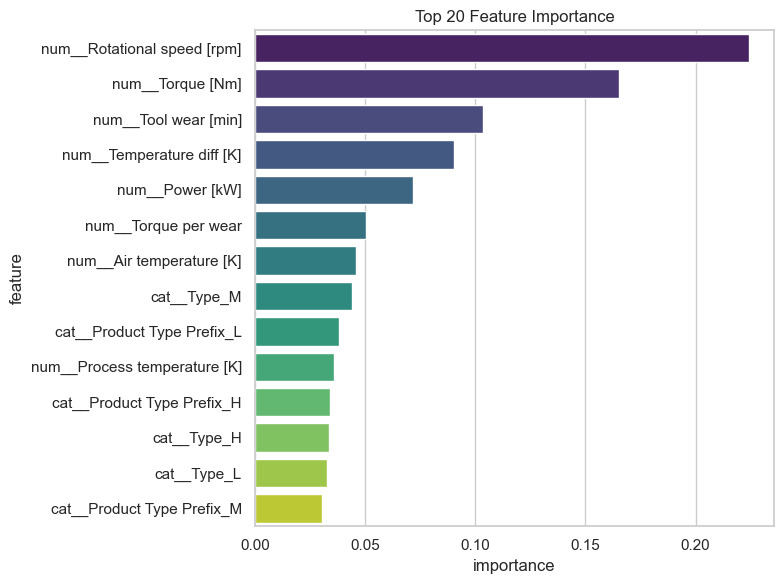

In [16]:
# Feature importance for interpretability (if available)
# Access estimator from pipeline for explainability
estimator = best_model.named_steps["model"]
prep = best_model.named_steps["preprocessor"]
# Extract transformed feature names from preprocessor
feature_names = prep.get_feature_names_out()

importance = None
# Tree models expose direct feature importances
if hasattr(estimator, "feature_importances_"):
    importance = estimator.feature_importances_
# Linear models use absolute coefficient magnitude
elif hasattr(estimator, "coef_"):
    coef = estimator.coef_
    if getattr(coef, "ndim", 1) == 2:
        coef = coef[0]
    importance = np.abs(coef)

if importance is not None:
    # Build and export ranked importance table
    fi_df = pd.DataFrame({"feature": feature_names, "importance": importance})
    fi_df = fi_df.sort_values("importance", ascending=False).head(20)
    fi_df.to_csv("reports/feature_importance_top20.csv", index=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=fi_df, x="importance", y="feature", palette="viridis")
    plt.title("Top 20 Feature Importance")
    plt.tight_layout()
    plt.show()

    fi_df.head(10)
else:
    print("Feature importance is not available for this estimator.")


In [17]:
# Illustrative business impact (replace with plant-specific cost estimates)
# Assign larger penalty to missed failures
COST_FN = 10000  # missed failure
# Assign smaller penalty to false alerts
COST_FP = 500    # false alert

tn, fp, fn, tp = confusion_matrix(y_valid, valid_pred).ravel()
# Compute illustrative validation-phase risk cost
estimated_cost = fn * COST_FN + fp * COST_FP

impact_df = pd.DataFrame({
    "metric": ["True Negatives", "False Positives", "False Negatives", "True Positives", "Estimated Validation Cost"],
    "value": [tn, fp, fn, tp, estimated_cost],
})
impact_df


,metric,value
0,True Negatives,26655
1,False Positives,201
2,False Negatives,212
3,True Positives,218
4,Estimated Validation Cost,2220500


## Deployment Notes
1. Serve `artifacts/best_model.joblib` through Streamlit/FastAPI.
2. Pass real-time process signals, output `failure_probability`, and trigger alert tiers.
3. Recalibrate threshold using actual downtime and false-alarm costs.
4. Monitor drift in speed/torque/wear distributions and retrain periodically.


## Conclusion
- The pipeline is now imbalance-aware, threshold-tuned, and deployment-ready.
- Model evaluation is linked to maintenance decision tradeoffs, not accuracy alone.
- Outputs in `reports/` and `submission.csv` provide a complete audit trail from training to inference.
